In [1]:
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import pandas as pd
import pickle
from collections import defaultdict

In [2]:
import os
print(os.getcwd())


/workspace


In [2]:
# Wczytanie danych
df = pd.read_csv("project_Data_Anal/tennis/dataset/tennis_data_2001_2025_FIXED.csv", low_memory=False)

# Konwersja daty
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

match_to_date = {
    (row['Winner'], row['Loser'], row['Surface']): row['Date']
    for _, row in df.iterrows()
}

# Usunięcie roku 2020
df = df[df['Date'].dt.year != 2020]

# Wybór i czyszczenie danych
df = df[['Winner', 'Loser', 'Surface', 'WPts', 'LPts', 'AvgW', 'AvgL']]

# Usuwamy mecze z brakami w punktach i kursach
df = df.dropna(subset=['WPts', 'LPts', 'AvgW', 'AvgL'])

# Usuń mecze na nawierzchni 'Carpet'
df = df[~df['Surface'].str.lower().eq('carpet')]

# Zamiana nazw graczy na ID
unique_players = pd.unique(df[['Winner', 'Loser']].values.ravel())
player_to_id = {player: i+1 for i, player in enumerate(unique_players)}
id_to_player = {v: k for k, v in player_to_id.items()}

df['p1'] = df['Winner'].map(player_to_id)
df['p2'] = df['Loser'].map(player_to_id)
df['y'] = 1  # p1 to zwycięzca

stan_df = df

# Dopasuj daty do stan_df (w razie czego można lepiej klucze znormalizować)
stan_df['Date'] = stan_df.apply(
    lambda row: match_to_date.get((row['Winner'], row['Loser'], row['Surface'])),
    axis=1
)

train_df = stan_df[stan_df['Date'].dt.year <= 2023].copy()
test_df = stan_df[stan_df['Date'].dt.year >= 2024].copy()

# Finalny DataFrame


In [3]:
points_per_player = defaultdict(list)

# Zbieramy punkty z obu stron (zwycięzcy i przegrani)
for _, row in train_df.iterrows():
    if row['WPts'] > 0:
        points_per_player[row['p1']].append(row['WPts'])
    if row['LPts'] > 0:
        points_per_player[row['p2']].append(row['LPts'])

# Obliczamy średnią liczbę punktów rankingowych
nPlayers = len(player_to_id)
player_strength = np.zeros(nPlayers)

for pid in range(1, nPlayers + 1):
    pts = points_per_player.get(pid, [])
    if pts:
        player_strength[pid - 1] = np.mean(pts)
    else:
        player_strength[pid - 1] = 0.0  # jeśli nie mamy danych → 0




In [4]:
model = CmdStanModel(stan_file='project_Data_Anal/tennis/model_elo.stan')

# Oblicz logitowe wartości punktów
train_df['p1Logit'] = np.log(train_df['WPts'])
train_df['p2Logit'] = np.log(train_df['LPts'])

# Oblicz oddsDiff z kursów bukmacherskich
train_df['oddsDiff'] = np.log(1 / train_df['AvgW']) - np.log(1 / train_df['AvgL'])

# Przygotuj siłę graczy z rankingu (np. odwrotność rankingu ATP)
# Upewnij się, że masz player_strength jako słownik lub wektor
# Zakładamy, że masz wcześniej przygotowane:
# player_strength = np.array([...])  # o długości nPlayers

stan_data_all = {
    'nGames': len(train_df),
    'nPlayers': len(player_to_id),
    'player1': train_df['p1'].tolist(),
    'player2': train_df['p2'].tolist(),
    'p1Logit': train_df['p1Logit'].tolist(),
    'p2Logit': train_df['p2Logit'].tolist(),
    'oddsDiff': train_df['oddsDiff'].tolist(),
    'playerStrength': player_strength.tolist()
}

# # Uruchom próbki z modelu
# fit = model.sample(
#     data=stan_data_all,
#     chains=4,
#     iter_sampling=1000,
#     iter_warmup=500,
#     seed=123
# )

In [ ]:
# WCZYTANIE LUB ZAPIS MODELU DO PLIKU ŻEBY NIE TRZEBA BYŁO RUNOWAĆ 2H TEGO GÓWNA

# with open("project_Data_Anal/tennis/stan_output2/model1.pkl", "wb") as f: # WRITE
#     pickle.dump(fit, f)

with open("project_Data_Anal/tennis/stan_output2/model1.pkl", "rb") as f: # READ
    fit = pickle.load(f)

idata_model1 = az.from_cmdstanpy(
    posterior=fit,
    observed_data={"p1Logit": train_df["p1Logit"].values},
    log_likelihood="log_lik"
)


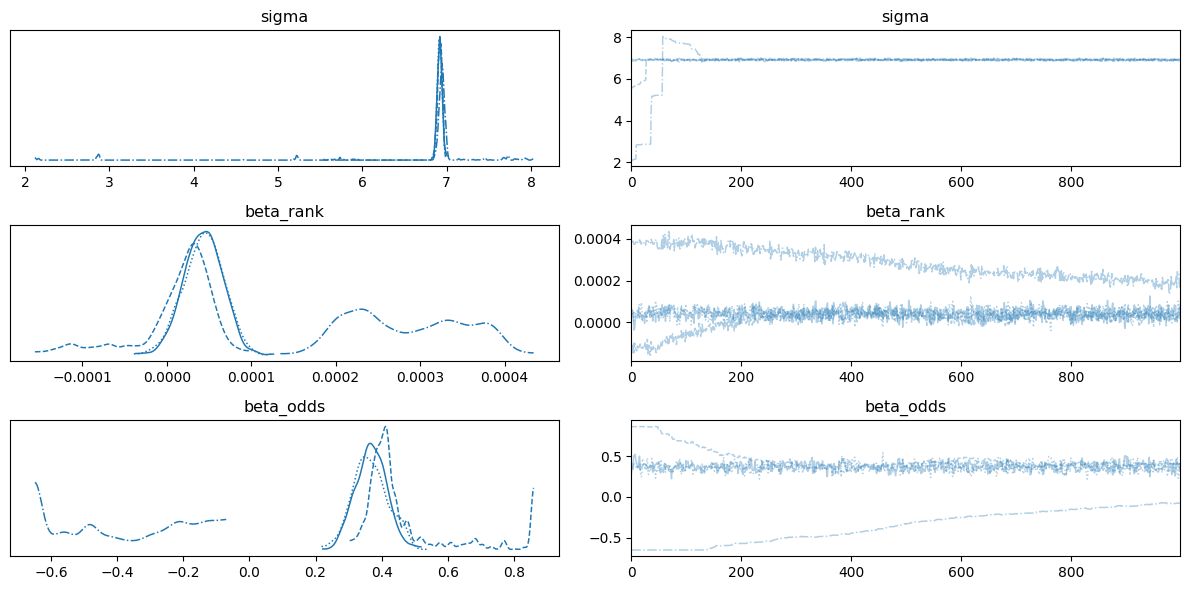

In [7]:
# # Trace plot tylko dla parametrów modelowanych
az.plot_trace(idata_model1, var_names=["sigma", "beta_rank", "beta_odds"])
plt.tight_layout()
plt.show()

In [8]:
# Załaduj posterior
beta_rank_samples = idata_model1.posterior['beta_rank'].stack(samples=("chain", "draw")).values
beta_odds_samples = idata_model1.posterior['beta_odds'].stack(samples=("chain", "draw")).values

# Przygotuj dane dla nowego meczu
def predict_win_probability(p1_id, p2_id, avgW, avgL, player_strength):
    strength_diff = player_strength[p1_id - 1] - player_strength[p2_id - 1]
    odds_diff = np.log(1 / avgW) - np.log(1 / avgL)

    # logit dla każdej próbki posteriora
    logits = beta_rank_samples * strength_diff + beta_odds_samples * odds_diff
    probs = 1 / (1 + np.exp(-logits))  # sigmoid

    # Średnie i przedział ufności
    p_mean = np.mean(probs)
    p_ci_lower = np.percentile(probs, 2.5)
    p_ci_upper = np.percentile(probs, 97.5)

    return p_mean, p_ci_lower, p_ci_upper


p_mean, ci_low, ci_high = predict_win_probability(
    p1_id=player_to_id['Djokovic N.'],
    p2_id=player_to_id['Sinner J.'],
    avgW=1.90, avgL=1.95,
    player_strength=player_strength
)

print(f"Prawdopodobieństwo wygranej Djokovica: {p_mean:.3f} (95% CI: {ci_low:.3f}–{ci_high:.3f})")

Prawdopodobieństwo wygranej Djokovica: 0.685 (95% CI: 0.327–0.988)


In [4]:
# Wczytanie danych
df = pd.read_csv("project_Data_Anal/tennis/dataset/tennis_data_2001_2025_FIXED.csv", low_memory=False)

# Konwersja daty
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

match_to_date = {
    (row['Winner'], row['Loser'], row['Surface']): row['Date']
    for _, row in df.iterrows()
}

# Usunięcie roku 2020
df = df[df['Date'].dt.year != 2020]

# Wybór i czyszczenie danych
df = df[['Winner', 'Loser', 'Surface', 'WPts', 'LPts', 'AvgW', 'AvgL',
         'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5']]

cols_to_convert = ['W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5']
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

df['dominance'] = (
    df[['W1', 'W2', 'W3', 'W4', 'W5']].fillna(0).sum(axis=1) -
    df[['L1', 'L2', 'L3', 'L4', 'L5']].fillna(0).sum(axis=1)
)
df['dominance_scaled'] = (df['dominance'] - df['dominance'].mean()) / df['dominance'].std()


# Usuwamy mecze z brakami w punktach i kursach
df = df.dropna(subset=['WPts', 'LPts', 'AvgW', 'AvgL'])

# Usuń mecze na nawierzchni 'Carpet'
df = df[~df['Surface'].str.lower().eq('carpet')]

# Zamiana nazw graczy na ID
unique_players = pd.unique(df[['Winner', 'Loser']].values.ravel())
player_to_id = {player: i+1 for i, player in enumerate(unique_players)}
id_to_player = {v: k for k, v in player_to_id.items()}

df['p1'] = df['Winner'].map(player_to_id)
df['p2'] = df['Loser'].map(player_to_id)
df['y'] = 1  # p1 to zwycięzca

stan_df = df

# Dopasuj daty do stan_df (w razie czego można lepiej klucze znormalizować)
stan_df['Date'] = stan_df.apply(
    lambda row: match_to_date.get((row['Winner'], row['Loser'], row['Surface'])),
    axis=1
)

train_df = stan_df[stan_df['Date'].dt.year <= 2023].copy()
test_df = stan_df[stan_df['Date'].dt.year >= 2024].copy()

# Finalny DataFrame


In [5]:
points_per_player = defaultdict(list)

# Zbieramy punkty z obu stron (zwycięzcy i przegrani)
for _, row in train_df.iterrows():
    if row['WPts'] > 0:
        points_per_player[row['p1']].append(row['WPts'])
    if row['LPts'] > 0:
        points_per_player[row['p2']].append(row['LPts'])

# Obliczamy średnią liczbę punktów rankingowych
nPlayers = len(player_to_id)
player_strength = np.zeros(nPlayers)

for pid in range(1, nPlayers + 1):
    pts = points_per_player.get(pid, [])
    if pts:
        player_strength[pid - 1] = np.mean(pts)
    else:
        player_strength[pid - 1] = 0.0  # jeśli nie mamy danych → 0

In [6]:
model = CmdStanModel(stan_file='project_Data_Anal/tennis/model_elo_dominance.stan')

# Oblicz logitowe wartości punktów
train_df['p1Logit'] = np.log(train_df['WPts'])
train_df['p2Logit'] = np.log(train_df['LPts'])

# Oblicz oddsDiff z kursów bukmacherskich
train_df['oddsDiff'] = np.log(1 / train_df['AvgW']) - np.log(1 / train_df['AvgL'])

# Przygotuj siłę graczy z rankingu (np. odwrotność rankingu ATP)
# Upewnij się, że masz player_strength jako słownik lub wektor
# Zakładamy, że masz wcześniej przygotowane:
# player_strength = np.array([...])  # o długości nPlayers

In [7]:
stan_data_all = {
    'nGames': len(train_df),
    'nPlayers': len(player_to_id),
    'player1': train_df['p1'].tolist(),
    'player2': train_df['p2'].tolist(),
    'p1Logit': train_df['p1Logit'].tolist(),
    'p2Logit': train_df['p2Logit'].tolist(),
    'oddsDiff': train_df['oddsDiff'].tolist(),
    'playerStrength': player_strength.tolist(),
    'dominance': train_df['dominance_scaled'].tolist()
}

# Uruchom próbki z modelu
# fit = model.sample(
#     data=stan_data_all,
#     chains=4,
#     iter_sampling=1000,
#     iter_warmup=500,
#     seed=123
# )

In [8]:
# Zapisz obiekt CmdStanFit (do późniejszego ładowania)
# with open("project_Data_Anal/tennis/stan_output2/fit_surface_elo.pkl", "wb") as f: # WRITE
#     pickle.dump(fit, f)

with open("project_Data_Anal/tennis/stan_output2/model2.pkl", "rb") as f: # READ
    fit = pickle.load(f)

# Konwersja do formatu ArviZ
idata_model2 = az.from_cmdstanpy(
    posterior=fit,
    observed_data={"p1Logit": train_df["p1Logit"].values},
    log_likelihood="log_lik"
)


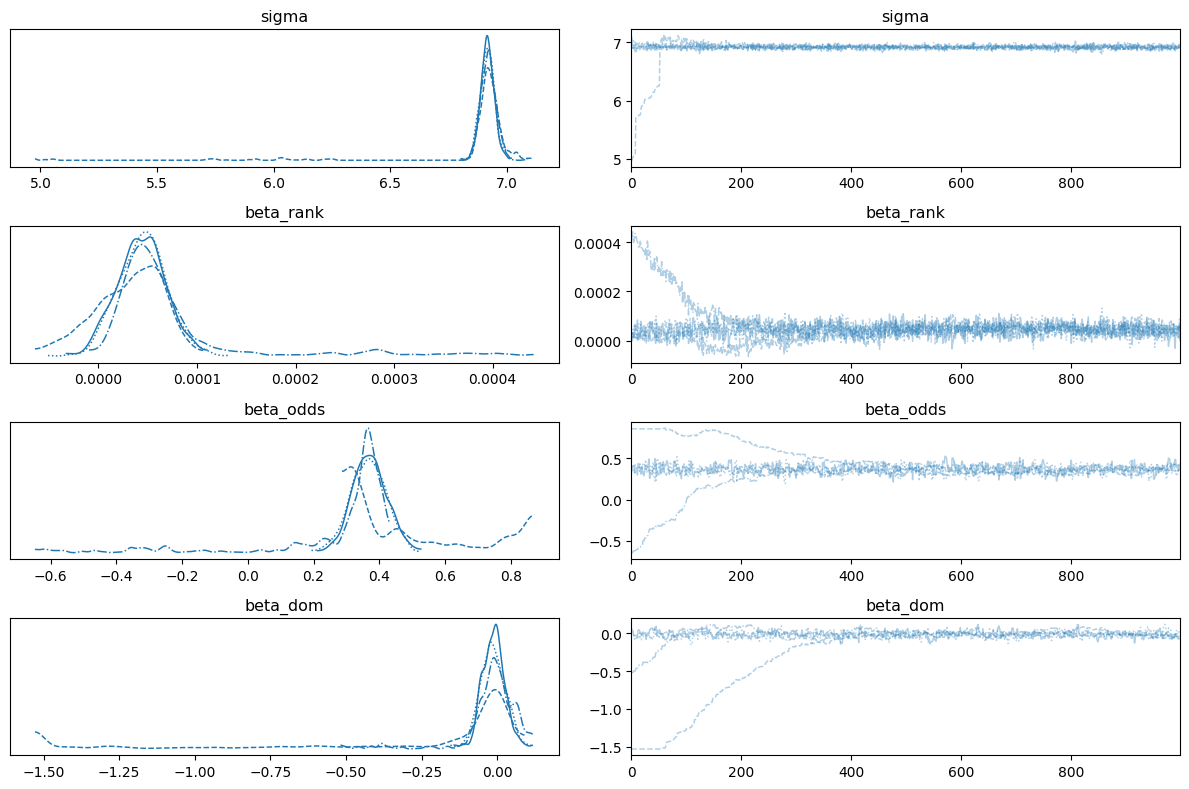

In [9]:
az.plot_trace(idata_model2, var_names=["sigma", "beta_rank", "beta_odds", "beta_dom"])
plt.tight_layout()
plt.show()

In [10]:
waic_model1 = az.waic(idata_model1)
waic_model2 = az.waic(idata_model2)

loo_model1 = az.loo(idata_model1)
loo_model2 = az.loo(idata_model2)

NameError: name 'idata_model1' is not defined

In [ ]:
print("WAIC model1:", waic_model1)
print("WAIC model2:", waic_model2)

print("LOO model1:", loo_model1)
print("LOO model2:", loo_model2)

WAIC model1: Computed from 4000 posterior samples and 14440 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -49577.06    17.00
p_waic      970.77        -

There has been a warning during the calculation. Please check the results.
WAIC model2: Computed from 4000 posterior samples and 14440 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -48431.43    12.84
p_waic       33.46        -
LOO model1: Computed from 4000 posterior samples and 14440 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -49014.25    14.84
p_loo      407.97        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      114    0.8%
   (0.70, 1]   (bad)      4430   30.7%
   (1, Inf)   (very bad) 9896   68.5%

LOO model2: Computed from 4000 posterior samples and 14440 observations log-likelihood matrix.

         Estimate  

In [ ]:
# METRYKI DLA MODELU 2

import numpy as np
from scipy.special import expit
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score


with open("project_Data_Anal/tennis/stan_output2/model1.pkl", "rb") as f: # READ
    fit = pickle.load(f)

idata_model2 = az.from_cmdstanpy(
    posterior=fit,
    observed_data={"p1Logit": train_df["p1Logit"].values},
    log_likelihood="log_lik"
)

# Wyciągnij średnie wartości parametrów z posterioru
posterior = fit.draws_pd()
beta_rank = posterior['beta_rank'].mean()
beta_odds = posterior['beta_odds'].mean()
beta_dom = posterior['beta_dom'].mean()

# Oblicz siły graczy
test_df['playerStrength1'] = test_df['p1'].map(lambda pid: player_strength[pid - 1])
test_df['playerStrength2'] = test_df['p2'].map(lambda pid: player_strength[pid - 1])

# Upewnij się, że kolumny są obecne
if 'oddsDiff' not in test_df:
    test_df['oddsDiff'] = np.log(1 / test_df['AvgW']) - np.log(1 / test_df['AvgL'])

if 'dominance_scaled' not in test_df:
    test_df['dominance'] = (
        test_df[['W1', 'W2', 'W3', 'W4', 'W5']].fillna(0).sum(axis=1) -
        test_df[['L1', 'L2', 'L3', 'L4', 'L5']].fillna(0).sum(axis=1)
    )
    test_df['dominance_scaled'] = (test_df['dominance'] - test_df['dominance'].mean()) / test_df['dominance'].std()

# Oblicz predyktor i prawdopodobieństwo zwycięstwa p1
test_df['predictor'] = (
    beta_rank * (test_df['playerStrength1'] - test_df['playerStrength2']) +
    beta_odds * test_df['oddsDiff'] +
    beta_dom * test_df['dominance_scaled']
)
test_df['predicted_proba'] = expit(test_df['predictor'])

# Stwórz balanced test set
positive = test_df.copy()
negative = test_df.copy()

negative[['p1', 'p2']] = negative[['p2', 'p1']]
negative['predicted_proba'] = 1 - negative['predicted_proba']
positive['y'] = 1
negative['y'] = 0

balanced_test = pd.concat([positive, negative], ignore_index=True)




In [ ]:

# Oblicz metryki
y_true = balanced_test['y']
y_pred = balanced_test['predicted_proba']

accuracy = accuracy_score(y_true, y_pred > 0.5)
logloss = log_loss(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

print(f"✅ Accuracy: {accuracy:.3f}")
print(f"📉 Log Loss: {logloss:.3f}")
print(f"🏆 ROC AUC: {auc:.3f}")


✅ Accuracy: 0.712
📉 Log Loss: 0.620
🏆 ROC AUC: 0.779


In [ ]:
# METRYKI DLA MODELU 1

import numpy as np
from scipy.special import expit
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score


with open("project_Data_Anal/tennis/stan_output2/model1.pkl", "rb") as f: # READ
    fit = pickle.load(f)
# Wyciągnij średnie wartości parametrów z posterioru
posterior = fit.draws_pd()
beta_rank = posterior['beta_rank'].mean()
beta_odds = posterior['beta_odds'].mean()
# beta_dom = posterior['beta_dom'].mean()

# Oblicz siły graczy
test_df['playerStrength1'] = test_df['p1'].map(lambda pid: player_strength[pid - 1])
test_df['playerStrength2'] = test_df['p2'].map(lambda pid: player_strength[pid - 1])

# Upewnij się, że kolumny są obecne
if 'oddsDiff' not in test_df:
    test_df['oddsDiff'] = np.log(1 / test_df['AvgW']) - np.log(1 / test_df['AvgL'])


# Oblicz predyktor i prawdopodobieństwo zwycięstwa p1
test_df['predictor'] = (
    beta_rank * (test_df['playerStrength1'] - test_df['playerStrength2']) +
    beta_odds * test_df['oddsDiff']
)
test_df['predicted_proba'] = expit(test_df['predictor'])

# Stwórz balanced test set
positive = test_df.copy()
negative = test_df.copy()

negative[['p1', 'p2']] = negative[['p2', 'p1']]
negative['predicted_proba'] = 1 - negative['predicted_proba']
positive['y'] = 1
negative['y'] = 0

balanced_test = pd.concat([positive, negative], ignore_index=True)




In [9]:

# Oblicz metryki
y_true = balanced_test['y']
y_pred = balanced_test['predicted_proba']

accuracy = accuracy_score(y_true, y_pred > 0.5)
logloss = log_loss(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

print(f"✅ Accuracy: {accuracy:.3f}")
print(f"📉 Log Loss: {logloss:.3f}")
print(f"🏆 ROC AUC: {auc:.3f}")


✅ Accuracy: 0.671
📉 Log Loss: 0.648
🏆 ROC AUC: 0.733
